# 🌲 Tree-Ring Watermarking: Invisible Fingerprints in Diffusion Models

**Tree-Ring Watermarking** is a method for embedding invisible, robust watermarks into images generated by diffusion models. The technique modifies the *initial noise vector* in **Fourier space** before sampling begins, rather than altering the image afterward.

This ensures the watermark is:
- 🔒 **Invisible**: no post-processing artifacts,
- 🔁 **Robust**: invariant to common distortions (crop, rotate, JPEG, etc.),
- 🔍 **Detectable**: via inversion using the original diffusion model (e.g., DDIM).

---

### 🧠 Basic Concept

Let $x_T \in \mathbb{R}^{C \times H \times W}$ be the initial Gaussian noise used to generate an image with a diffusion model.

We modify it in **Fourier space**:

$$
\mathcal{F}(x_T)_i =
\begin{cases}
k^*_i & \text{if } i \in \mathcal{M} \\
\mathcal{N}(0, 1) & \text{otherwise}
\end{cases}
$$

- $\mathcal{F}$ is the 2D Fourier transform (with shift),
- $\mathcal{M}$ is a mask (e.g. a ring around the center),
- $k^*$ is the **watermark key** inserted into that region.

After watermarking, we generate the image $x_0$ using the diffusion model:

$$
x_0 = D_\theta(x_T)
$$

To detect the watermark, we use **DDIM inversion**:

$$
x_T' = D_\theta^\dagger(x_0)
$$

Then we compute the **detection distance** (e.g., L1) in the masked Fourier region:

$$
\text{distance} = \frac{1}{|\mathcal{M}|} \sum_{i \in \mathcal{M}} \left| \mathcal{F}(x_T')_i - k^*_i \right|
$$

If this distance is below a threshold $\tau$, we conclude the image is watermarked.

---

### 📌 Why "Tree-Ring"?

The watermark pattern is often composed of **concentric rings** in Fourier space — similar to growth rings in a tree cross-section. This structure offers:
- **Rotational invariance**,
- **Robustness to spatial distortions**,
- **Statistical similarity to Gaussian noise** when properly designed.

---

In this notebook, we will:
1. Generate synthetic noise and a tree-ring pattern,
2. Embed the watermark into the noise,
3. Simulate forward and inverse diffusion,
4. Detect the watermark using the simplified detection formula above.

We assume you’re already familiar with how diffusion models work, and what DDIM is.

---

## 📦 Pretrained Diffusion Model

In this demo, we use the **pretrained diffusion model** provided by [OpenAI's Guided Diffusion repository](https://github.com/openai/guided-diffusion).

Specifically, we use the **256×256 class-conditional diffusion model trained on ImageNet**. This model is based on a large UNet architecture trained to reverse Gaussian noise into realistic images.

- It supports **DDPM** and **DDIM** sampling.
- It operates in **pixel space** rather than latent space.
- It accepts an optional **class label** as input (e.g., "dog", "car").

This model is ideal for our purposes because it:
- Allows us to inject a watermark directly into the **initial noise**,
- Supports **DDIM inversion**, which is essential for watermark detection,
- Is open-sourced and well-documented for reproducible research.

We do not retrain the model — instead, we treat it as a **frozen black box** that maps noise to image and image back to noise.



# 1. Prepare model and dataset

In [1]:
# Watermarking parameters
w_seed = 999999
w_channel = 0
w_pattern = 'rand'
w_mask_shape = 'circle'
w_radius = 0.5
w_measurement = 'l1_complex'
w_injection = 'complex'
w_pattern_const  = 0

With the help of custom scripts from Tree-Ring (inverse_stable_diffusion.py & modified_stable_diffusion.py),
we can use the Stable Diffusion 2.1 model to:
- Generate images from text prompts,
- Invert generated images back to their original noise (and optionally, the text prompt).

In [2]:
# Get the model.
import torch
from diffusers import DPMSolverMultistepScheduler
from inverse_stable_diffusion import InversableStableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = InversableStableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
)
pipe = pipe.to(device)

c:\Users\mike8\anaconda3\envs\ai_env\lib\site-packages\diffusers\pipelines\pipeline_loading_utils.py:285: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-1-base currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-1-base is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## 📝 Dataset: `Gustavosta/Stable-Diffusion-Prompts`

For this demo, we use the publicly available dataset [`Gustavosta/Stable-Diffusion-Prompts`](https://huggingface.co/datasets/Gustavosta/stable-diffusion-prompts), hosted on Hugging Face Datasets.

This dataset contains a curated collection of **high-quality text prompts** used to guide Stable Diffusion-style image generation. The prompts are designed to elicit rich, detailed, and creative visual scenes from text-to-image models.

### 📦 Dataset Highlights
- 💬 **Text-only** dataset — each sample is a prompt string.
- 🧠 Originally intended for benchmarking prompt engineering in generative models.
- 📚 Useful for evaluating conditional generation, diversity, and robustness.

### 🔍 Why we use it here:
- It provides a wide variety of realistic and artistic prompts.
- It enables repeatable generation and watermarking experiments across multiple prompt types.
- It is compact and easy to use, requiring no image storage.

We use this dataset to supply the **conditioning input (prompt)** for our diffusion model when generating watermarked and non-watermarked images.


In [3]:
# Prepare the dataset
from datasets import load_dataset
dataset = load_dataset('Gustavosta/Stable-Diffusion-Prompts')['test']
prompt_key = 'Prompt'

In [4]:
"""
The instance contains `Prompt`, which is used to generate the image.
"""
dataset[0]

{'Prompt': 'young, curly haired, redhead Natalie Portman  as a optimistic!, cheerful, giddy medieval innkeeper in a dark medieval inn. dark shadows, colorful, candle light,  law contrasts, fantasy concept art by Jakub Rozalski, Jan Matejko, and J.Dickenson'}

# 2. Prepare the watermarking pattern, which will be injected into the image with the mask.

In [5]:
# To mimic the real-world case, we assume the prompt is unknown at the detection time.
tester_prompt = '' 
text_embeddings = pipe.get_text_embedding(tester_prompt) # Generate the text embedding for the tester prompt, which is used to get the latent from given image (test image) through the forward diffusion process.

In [6]:
text_embeddings.shape # The text embedding is a 77x1024 tensor where 77 is the number of tokens in the prompt and 1024 is the dimension of the text embedding.

torch.Size([1, 77, 1024])

In [7]:
from utils.random import set_random_seed
import numpy as np
import copy

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?.*?")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*?.*?")

def circle_mask(size=64, r=10, x_offset=0, y_offset=0):
    """
    Create a circular mask of given size and radius.
    Parameters:
        - size: The size of the mask (width and height).
        - r: The radius of the circle.
        - x_offset: The x-coordinate offset for the center of the circle.
        - y_offset: The y-coordinate offset for the center of the circle.
    Returns:
        - mask: A boolean mask where True values represent the circular area.

    Reference: https://stackoverflow.com/questions/69687798/generating-a-soft-circluar-mask-using-numpy-python-3
    """
    x0 = y0 = size // 2
    x0 += x_offset
    y0 += y_offset
    y, x = np.ogrid[:size, :size]
    y = y[::-1]
    return ((x - x0) ** 2 + (y - y0) ** 2) <= r**2


def get_watermarking_pattern(
    pipe,
    w_seed: int,
    w_pattern: str,
    w_radius: int,
    device: str,
    shape: tuple | None = None,
):
    """
    Generate a watermarking pattern based on the specified parameters.
    Parameters:
        - pipe: The pipeline object used for generating the watermarking pattern.
        - w_seed: The seed for random number generation.
        - w_pattern: The type of watermarking pattern to generate.
        - w_radius: The radius for the watermarking pattern.
        - device: The device to use for computation (e.g., "cuda" or "cpu").
        - shape: The shape of the watermarking pattern. If None, a random shape is used.
    Returns:
        - gt_patch: The generated watermarking pattern.

    Two important functions used here are:
        `torch.fft.fft2`: Computes the 2D discrete Fourier Transform.
        `torch.fft.fftshift`: Shifts the zero-frequency component to the center of the spectrum.
    """


    set_random_seed(w_seed)
    if shape is not None:
        gt_init = torch.randn(*shape, device=device)
    else:
        gt_init = pipe.get_random_latents()

    if "seed_ring" in w_pattern:
        gt_patch = gt_init

        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(w_radius, 0, -1):
            tmp_mask = circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask).to(device)

            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()
    elif "seed_zeros" in w_pattern:
        gt_patch = gt_init * 0
    elif "seed_rand" in w_pattern:
        gt_patch = gt_init
    elif "rand" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))
        gt_patch[:] = gt_patch[0]
    elif "zeros" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
    elif "const" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
        gt_patch += w_pattern_const
    elif "ring" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))

        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(w_radius, 0, -1):
            tmp_mask = circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask).to(device)

            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()

    return gt_patch

In [8]:
gt_patch = get_watermarking_pattern(
    pipe,
    w_seed=w_seed,
    w_pattern=w_pattern,
    w_radius=w_radius,
    device=device,
    shape=None,
)


## Visualise different patterns of watermarking

In [9]:
import matplotlib.pyplot as plt

def visualise_noise(x):
    """
    Visualize the noise or pattern.
    """
    # Convert the tensor to a numpy array and move it to CPU
    x_np = x.real.cpu().numpy()

    fig, axes = plt.subplots(1, x_np.shape[0], figsize=(x_np.shape[0] * 5, 5))
    for idx, ax in enumerate(axes):
        ax.imshow(x_np[idx], cmap="gray")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Pattern: rand


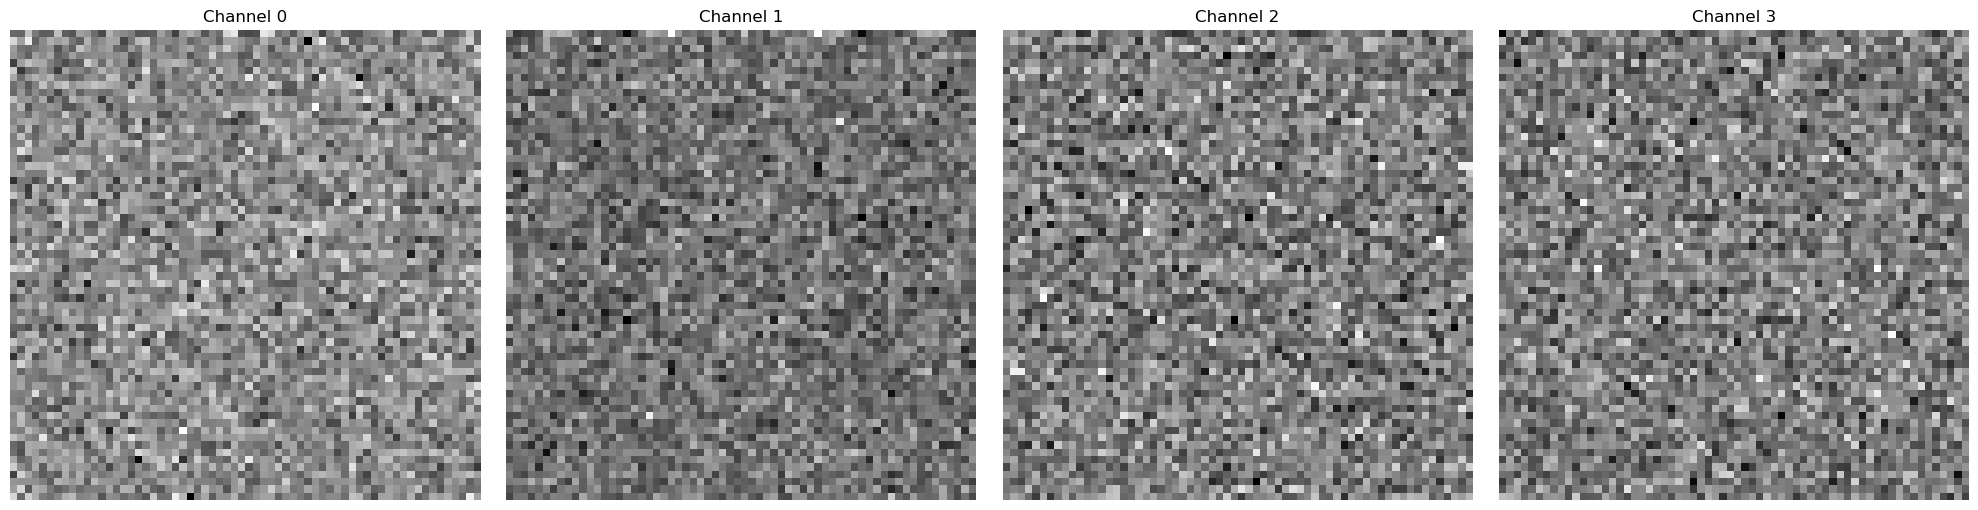

Pattern: zeros


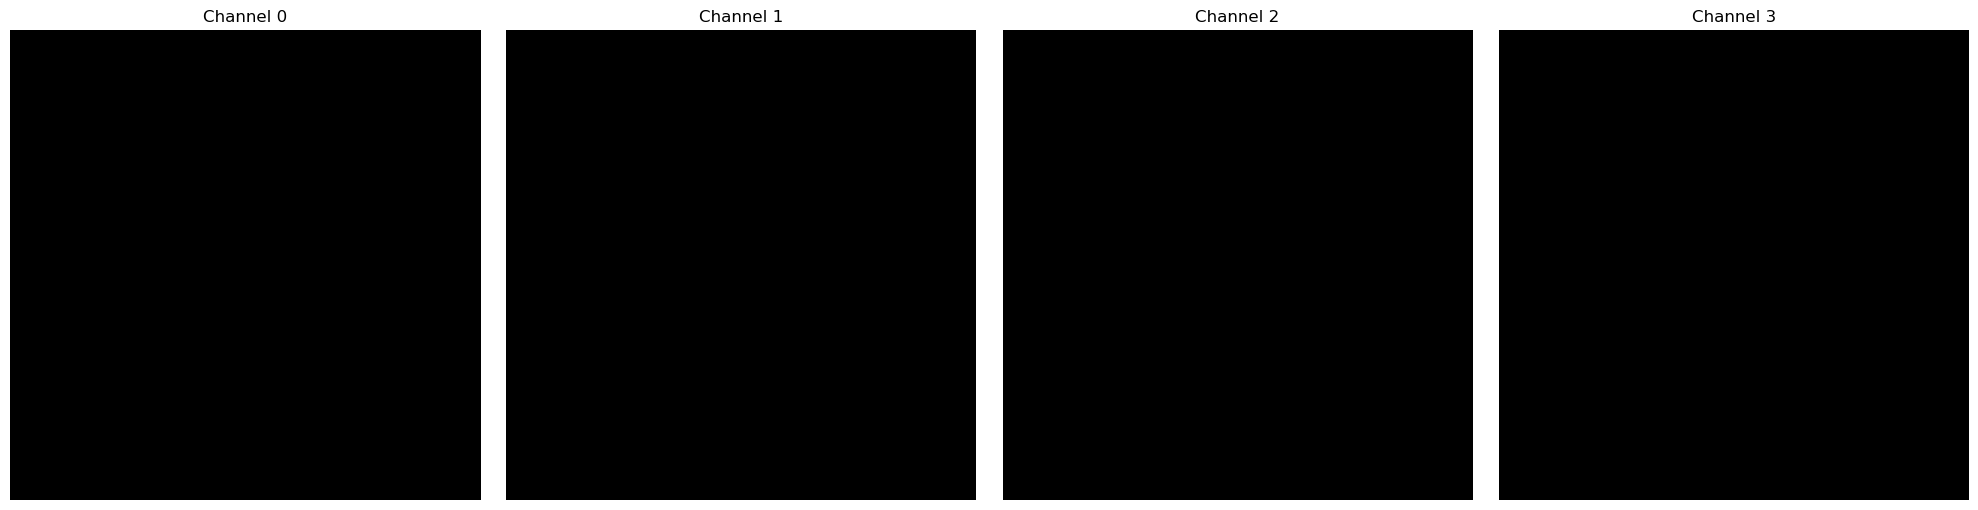

Pattern: const


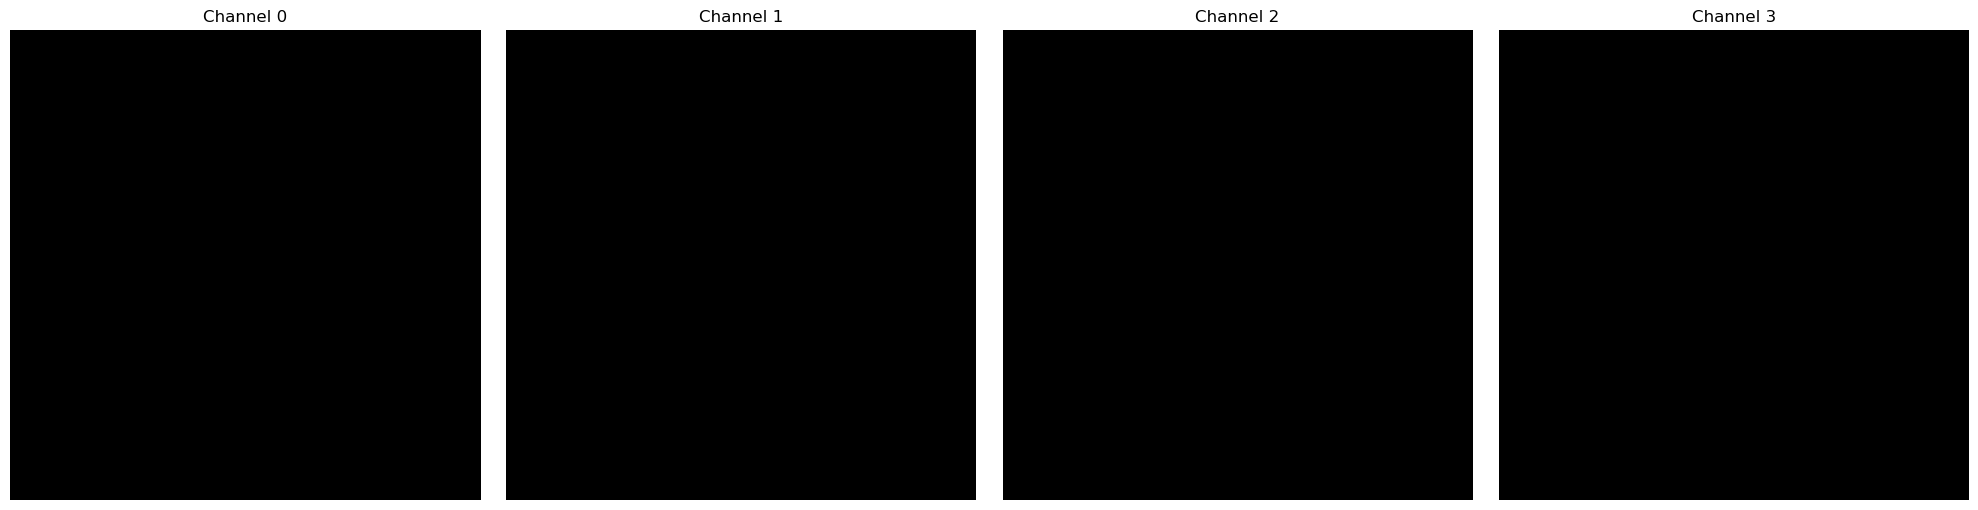

Pattern: seed_rand


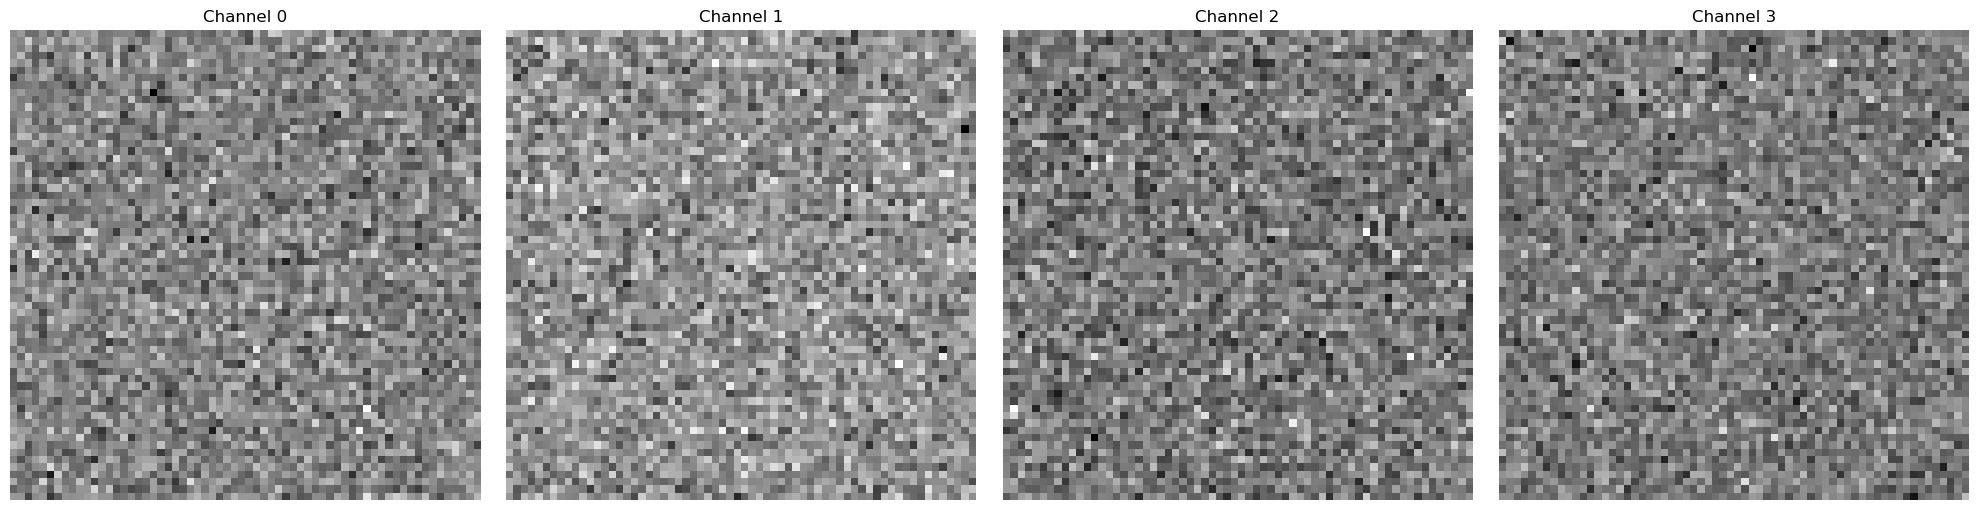

Pattern: seed_zeros


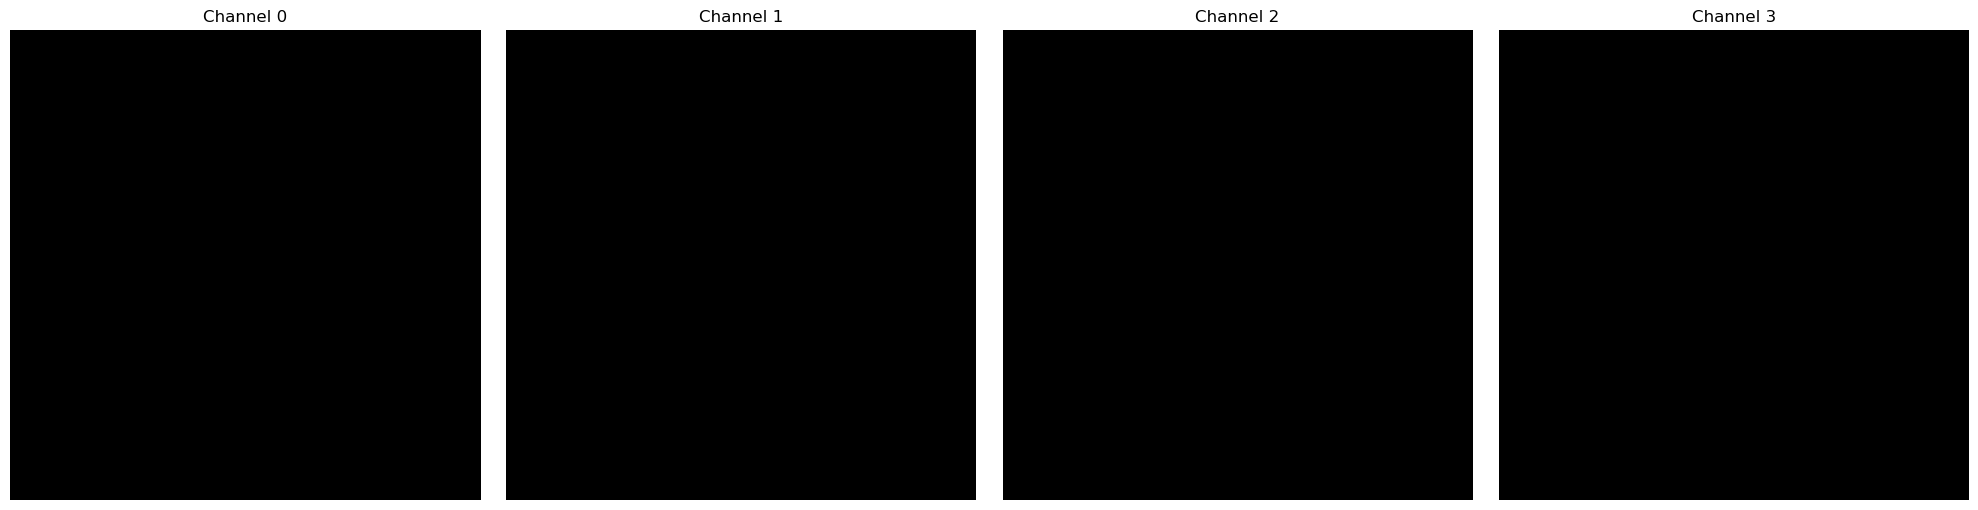

Pattern: seed_ring


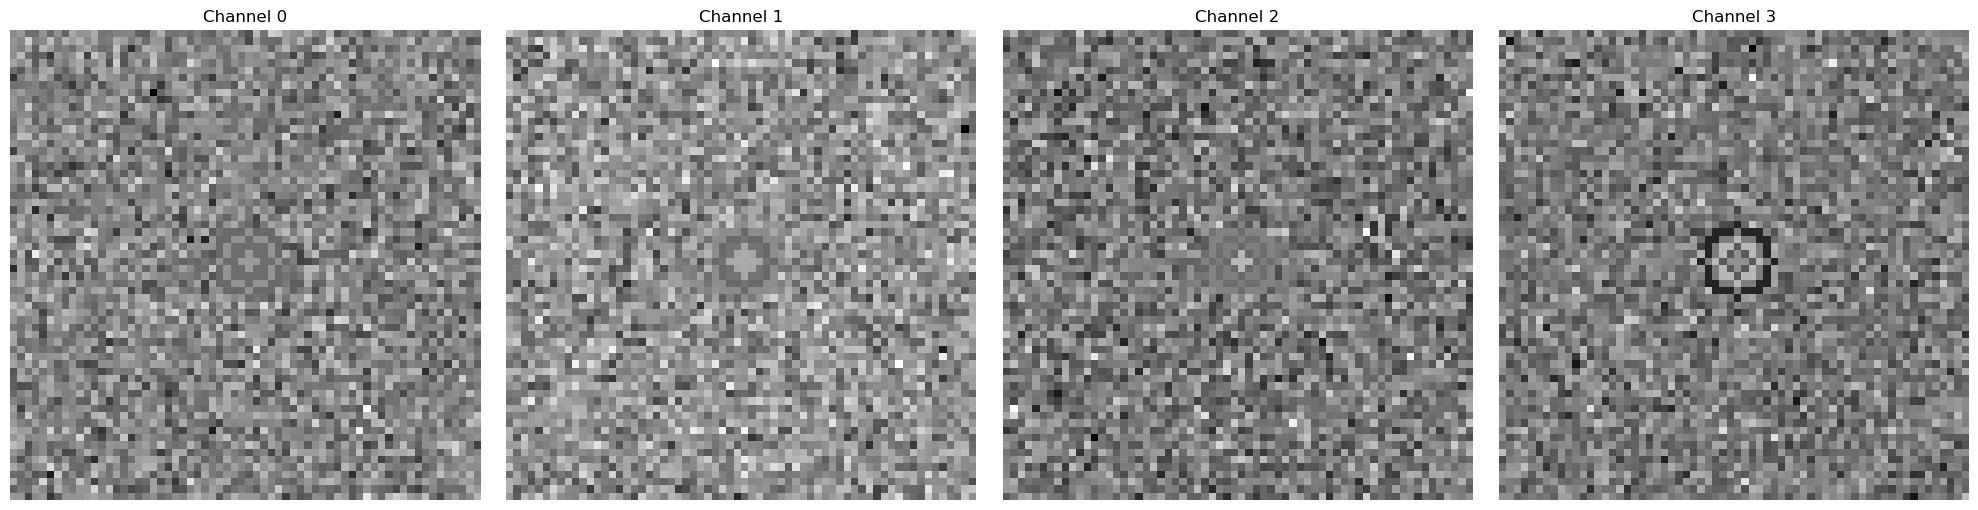

Pattern: ring


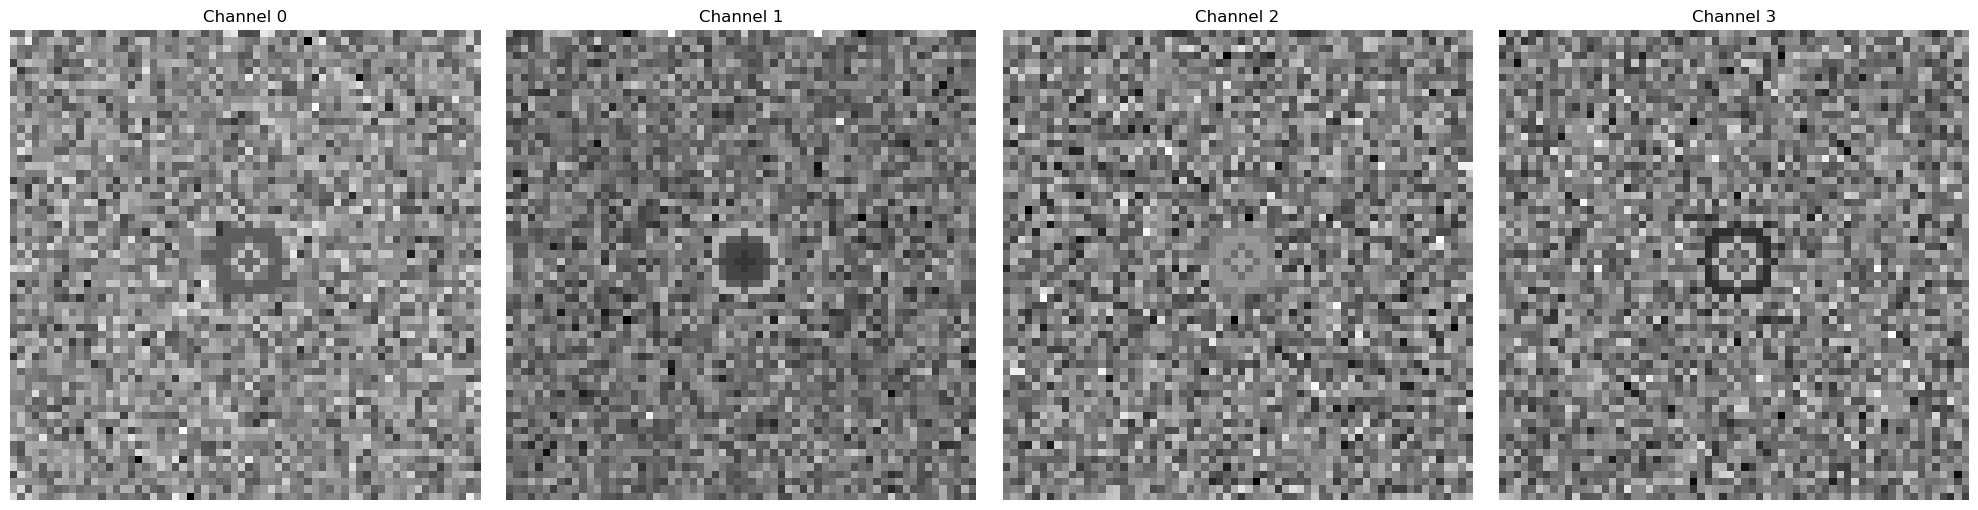

In [10]:
# Go through all the watermarking patterns to visualise them
for w_pattern in [
    "rand",
    "zeros",
    "const",
    "seed_rand",
    "seed_zeros",
    "seed_ring",
    "ring",
]:
    print(f"Pattern: {w_pattern}")
    vis_patch = get_watermarking_pattern(
        pipe,
        w_seed=w_seed,
        w_pattern=w_pattern,
        w_radius=5,
        device=device,
        shape=None,
    )
    visualise_noise(vis_patch[0])

In [11]:
# Generation parameters
gen_seed = 0
num_images = 1
guidance_scale = 7.5
num_inference_steps = 50
image_length = 512

# 3. Prepare latent for generation

In [12]:
i = 5 # Example index

# Prepare the generation
current_prompt = dataset[i][prompt_key]
print(f"Prompt: {current_prompt}")
set_random_seed(gen_seed)


Prompt: american portrait of one retrofuturistic assassin surrounded by advanced brutalist architecture. highly detailed science fiction, rich colors, high contrast, gloomy atmosphere, dark background. trending on artstation an ultrafine hyperdetailed colorfull illustration by tsutomu nihei by emil melmoth, gustave dore, craig mullins, yoji shinkawa, luis royo, zaha hadid, pete morbacher, female, feminine, art deco, new baroque, intricate linework


## 3.1 Without watermarking

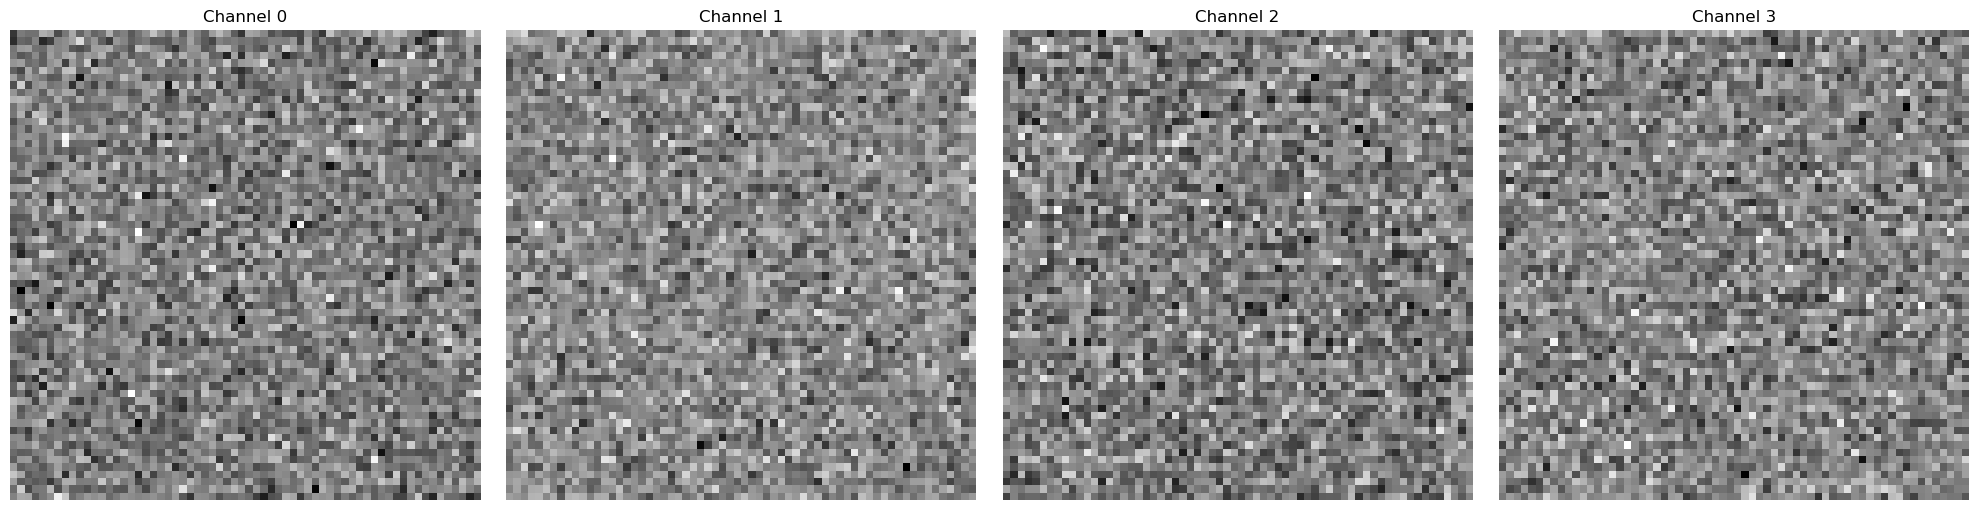

In [13]:
init_latents_no_w = pipe.get_random_latents()
# Visualize the initial latents (noise) without watermarking
visualise_noise(init_latents_no_w[0])

In [14]:
# Generate the image from the initial latents without watermarking
outputs_no_w = pipe(
    current_prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,  # how strongly to follow the prompt
    num_inference_steps=num_inference_steps,  # how many steps of denoising to do
    height=image_length,
    width=image_length,
    latents=init_latents_no_w,
)
orig_image_no_w = outputs_no_w.images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (93 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['morbacher , female , feminine , art deco , new baroque , intricate linework']


  0%|          | 0/50 [00:00<?, ?it/s]

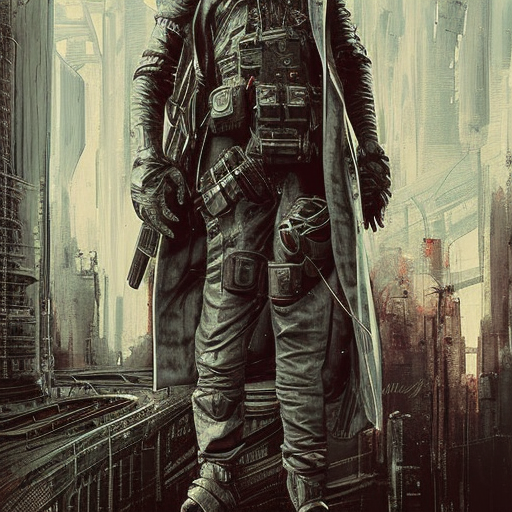

In [15]:
orig_image_no_w

## 3.2 With watermarking

In [16]:
# Do another forward pass with the watermarking pattern
if init_latents_no_w is None:
    set_random_seed(gen_seed)
    init_latents_w = pipe.get_random_latents()
else:
    init_latents_w = copy.deepcopy(init_latents_no_w)

In [17]:
def get_watermarking_mask(
    init_latents_w,
    w_mask_shape: str,
    w_channel: int,
    w_radius: float,
    device: str,
):
    """
    Generate a watermarking mask based on the specified parameters.
    Parameters:
        - init_latents_w: The initial latents with watermarking.
        - w_mask_shape: The shape of the watermarking mask (e.g., "circle", "square").
        - w_channel: The channel to apply the watermarking mask to (-1 for all channels).
        - w_radius: The radius for the watermarking mask.
        - device: The device to use for computation (e.g., "cuda" or "cpu").
    Returns:
        - watermarking_mask: The generated watermarking mask.
    """
    watermarking_mask = torch.zeros(init_latents_w.shape, dtype=torch.bool).to(device)

    if w_mask_shape == "circle":
        np_mask = circle_mask(init_latents_w.shape[-1], r=w_radius)
        torch_mask = torch.tensor(np_mask).to(device)

        if w_channel == -1:
            # all channels
            watermarking_mask[:, :] = torch_mask
        else:
            watermarking_mask[:, w_channel] = torch_mask
    elif w_mask_shape == "square":
        anchor_p = init_latents_w.shape[-1] // 2
        if w_channel == -1:
            # all channels
            watermarking_mask[
                :,
                :,
                anchor_p - w_radius : anchor_p + w_radius,
                anchor_p - w_radius : anchor_p + w_radius,
            ] = True
        else:
            watermarking_mask[
                :,
                w_channel,
                anchor_p - w_radius : anchor_p + w_radius,
                anchor_p - w_radius : anchor_p + w_radius,
            ] = True
    elif w_mask_shape == "no":
        pass
    else:
        raise NotImplementedError(f"w_mask_shape: {w_mask_shape}")

    return watermarking_mask

In [18]:
watermarking_mask = get_watermarking_mask(
    init_latents_w,
    w_mask_shape=w_mask_shape,
    w_channel=w_channel,
    w_radius=w_radius, 
    device=device,
)

### Visualise the watermarking mask

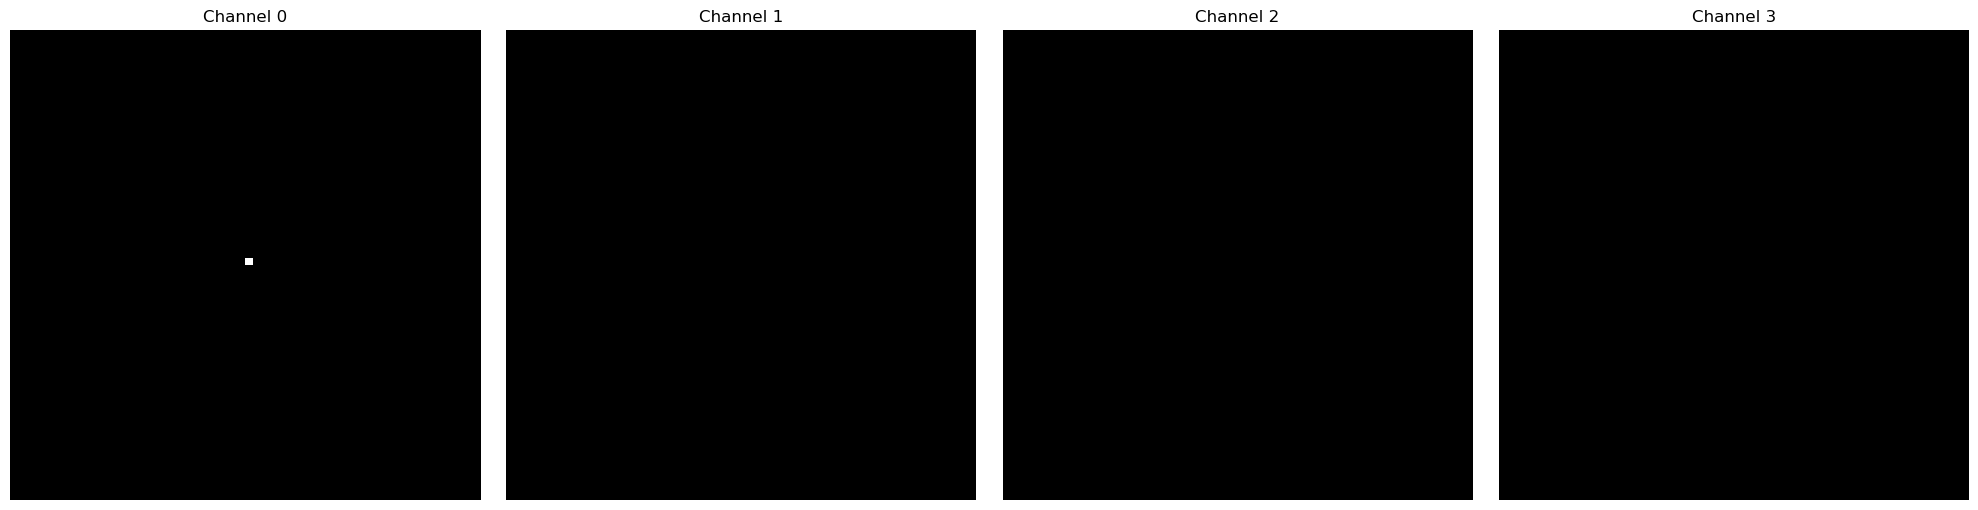

In [19]:
visualise_noise(watermarking_mask[0].float()) 

In [20]:
def inject_watermark(init_latents_w, watermarking_mask, gt_patch, w_injection: str):
    """
    Inject the watermark into the latents.
    Parameters:
        - init_latents_w: The initial latents with watermarking.
        - watermarking_mask: The mask indicating where to inject the watermark.
        - gt_patch: The watermark pattern to be injected.
        - w_injection: The method of watermark injection (e.g., "complex", "seed").
    Returns:
        - init_latents_w: The latents with the watermark injected.
    """
    # Perform FFT on the latents
    init_latents_w_fft = torch.fft.fftshift(torch.fft.fft2(init_latents_w), dim=(-1, -2))

    # Inject the watermark into the latents in FFT domain
    if w_injection == 'complex':
        init_latents_w_fft[watermarking_mask] = gt_patch[watermarking_mask].clone()
    elif w_injection == 'seed':
        init_latents_w[watermarking_mask] = gt_patch[watermarking_mask].clone()
        return init_latents_w
    else:
        NotImplementedError(f'w_injection: {w_injection}')

    # Perform inverse FFT to get the latents with watermark
    init_latents_w = torch.fft.ifft2(torch.fft.ifftshift(init_latents_w_fft, dim=(-1, -2))).real

    return init_latents_w

In here, we perform:

$$
\mathcal{F}(x_T)_i =
\begin{cases}
k^*_i & \text{if } i \in \mathcal{M} \\
\mathcal{N}(0, 1) & \text{otherwise}
\end{cases}
$$

In [21]:
init_latents_w = inject_watermark(
    init_latents_w,
    watermarking_mask,
    gt_patch,
    w_injection=w_injection,
)

### Visualised the watermarked latents

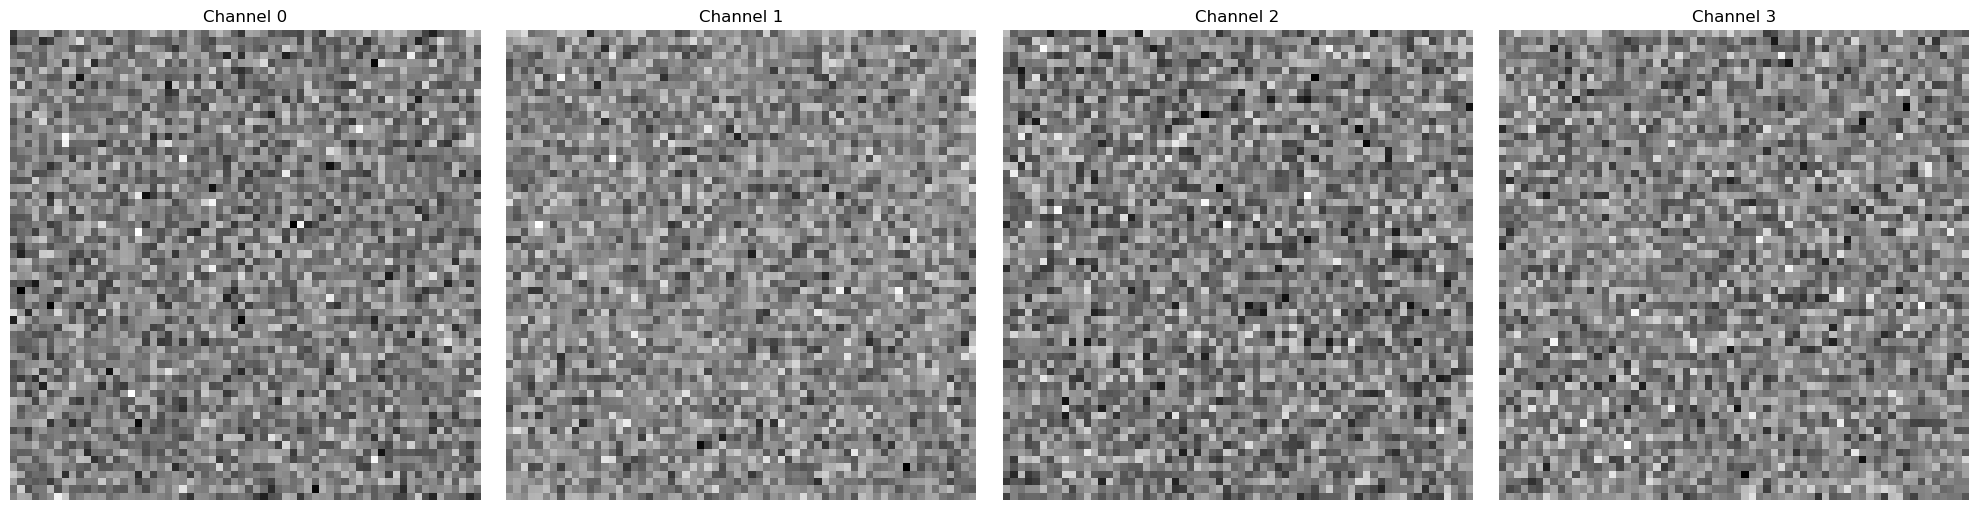

In [22]:
visualise_noise(init_latents_w[0]) # Visualize the latents with watermarking

In [23]:
outputs_w = pipe(
    current_prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    latents=init_latents_w,
)
orig_image_w = outputs_w.images[0]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['morbacher , female , feminine , art deco , new baroque , intricate linework']


  0%|          | 0/50 [00:00<?, ?it/s]

### Compare watermarked and non-watermarked images

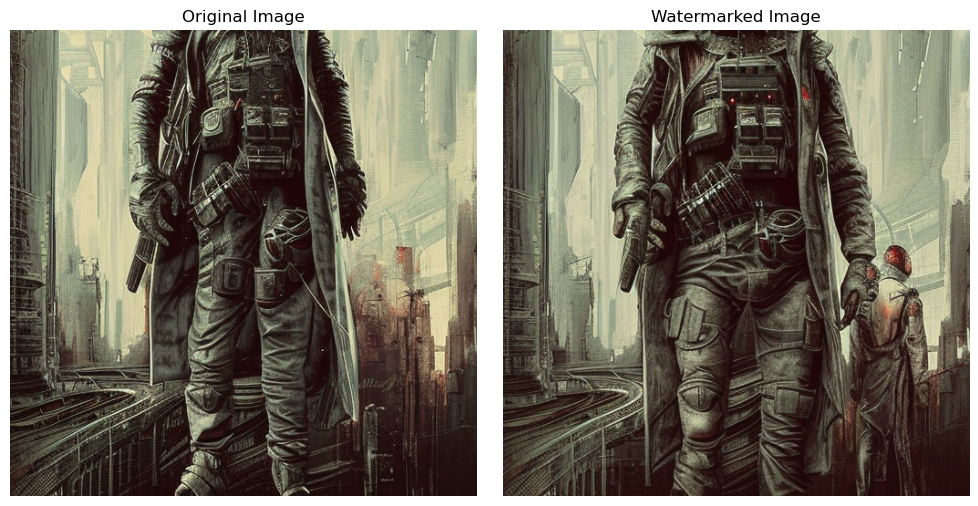

In [24]:
# visulise the original image and the watermarked image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_image_no_w)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(orig_image_w)
axes[1].set_title("Watermarked Image")
axes[1].axis("off")
plt.tight_layout()
plt.show()


# 4. Attack the images

In [56]:
# Attacking parameters
r_degree = 15
jpeg_ratio = None 
crop_scale = 0.95
crop_ratio = 0.95
gaussian_blur_r = 0.2
gaussian_std = 0.003
brightness_factor = None 
rand_aug = 0

test_num_inference_steps = 50
reference_model = None
reference_model_pretrain = None
run_name = "test"

In [57]:
from torchvision import transforms
from PIL import Image, ImageFilter

def image_distortion(
    img1,
    img2,
    seed,
    r_degree,
    jpeg_ratio,
    crop_scale,
    crop_ratio,
    gaussian_blur_r,
    gaussian_std,
    brightness_factor,
):
    """
    Apply various image distortions to two images.
    Parameters:
        - img1: The first image to be distorted.
        - img2: The second image to be distorted.
        - seed: The seed for random number generation.
        - r_degree: The degree of rotation to apply to the images.
        - jpeg_ratio: The JPEG compression ratio to apply to the images.
        - crop_scale: The scale for random cropping.
        - crop_ratio: The aspect ratio for random cropping.
        - gaussian_blur_r: The radius for Gaussian blur.
        - gaussian_std: The standard deviation for Gaussian noise.
        - brightness_factor: The factor for brightness adjustment.
    Returns:
        - img1: The distorted first image.
        - img2: The distorted second image.
    """
    if r_degree is not None:
        img1 = transforms.RandomRotation((r_degree, r_degree))(img1)
        img2 = transforms.RandomRotation((r_degree, r_degree))(img2)

    if jpeg_ratio is not None:
        img1.save(f"tmp_{jpeg_ratio}_{run_name}.jpg", quality=jpeg_ratio)
        img1 = Image.open(f"tmp_{jpeg_ratio}_{run_name}.jpg")
        img2.save(f"tmp_{jpeg_ratio}_{run_name}.jpg", quality=jpeg_ratio)
        img2 = Image.open(f"tmp_{jpeg_ratio}_{run_name}.jpg")

    if crop_scale is not None and crop_ratio is not None:
        set_random_seed(seed)
        img1 = transforms.RandomResizedCrop(
            img1.size,
            scale=(crop_scale, crop_scale),
            ratio=(crop_ratio, crop_ratio),
        )(img1)
        set_random_seed(seed)
        img2 = transforms.RandomResizedCrop(
            img2.size,
            scale=(crop_scale, crop_scale),
            ratio=(crop_ratio, crop_ratio),
        )(img2)

    if gaussian_blur_r is not None:
        img1 = img1.filter(ImageFilter.GaussianBlur(radius=gaussian_blur_r))
        img2 = img2.filter(ImageFilter.GaussianBlur(radius=gaussian_blur_r))

    if gaussian_std is not None:
        img_shape = np.array(img1).shape
        g_noise = np.random.normal(0, gaussian_std, img_shape) * 255
        g_noise = g_noise.astype(np.uint8)
        img1 = Image.fromarray(np.clip(np.array(img1) + g_noise, 0, 255))
        img2 = Image.fromarray(np.clip(np.array(img2) + g_noise, 0, 255))

    if brightness_factor is not None:
        img1 = transforms.ColorJitter(brightness=brightness_factor)(img1)
        img2 = transforms.ColorJitter(brightness=brightness_factor)(img2)

    return img1, img2

In [58]:
# Attack the image
orig_image_no_w_auged, orig_image_w_auged = image_distortion(
    orig_image_no_w,
    orig_image_w,
    gen_seed,
    r_degree=r_degree,
    jpeg_ratio=jpeg_ratio,
    crop_scale=crop_scale,
    crop_ratio=crop_ratio,
    gaussian_blur_r=gaussian_blur_r,
    gaussian_std=gaussian_std,
    brightness_factor=brightness_factor,
)

## Visualise the distored images

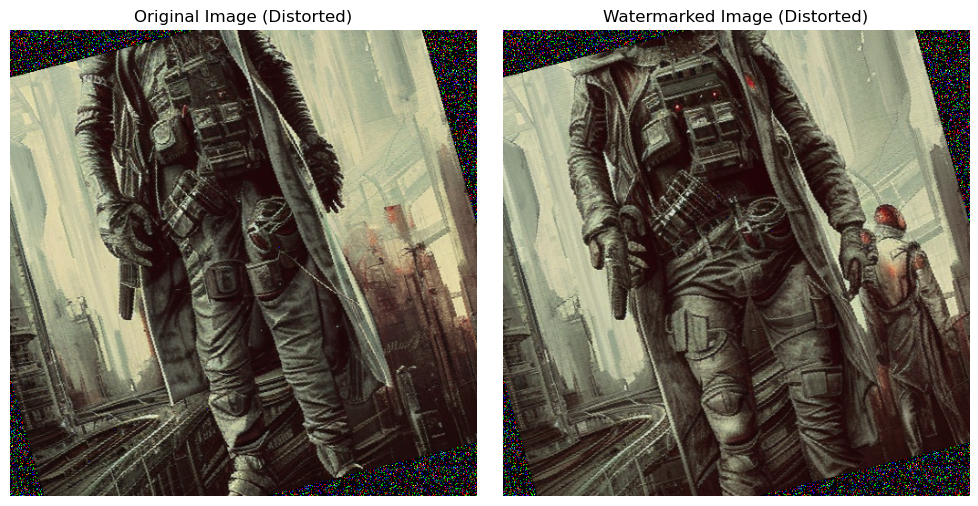

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_image_no_w_auged)
axes[0].set_title("Original Image (Distorted)")
axes[0].axis("off")
axes[1].imshow(orig_image_w_auged)
axes[1].set_title("Watermarked Image (Distorted)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [60]:
def transform_img(image, target_size=512):
    tform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ]
    )
    image = tform(image)
    return 2.0 * image - 1.0

# 5. From Image to Latents

In [61]:
# reverse img without watermarking
img_no_w = transform_img(orig_image_no_w_auged).unsqueeze(0).to(text_embeddings.dtype).to(device)
image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)

reversed_latents_no_w = pipe.forward_diffusion(
    latents=image_latents_no_w,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=test_num_inference_steps,
)

# reverse img with watermarking
img_w = transform_img(orig_image_w_auged).unsqueeze(0).to(text_embeddings.dtype).to(device)
image_latents_w = pipe.get_image_latents(img_w, sample=False)

reversed_latents_w = pipe.forward_diffusion(
    latents=image_latents_w,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=test_num_inference_steps,
)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [62]:
def eval_watermark(
    reversed_latents_no_w,
    reversed_latents_w,
    watermarking_mask,
    gt_patch,
    w_measurement: str,
):
    """
    Evaluate the watermarking performance based on the specified measurement method.
    Parameters:
        - reversed_latents_no_w: The latents without watermarking.
        - reversed_latents_w: The latents with watermarking.
        - watermarking_mask: The mask indicating the watermarking area.
        - gt_patch: The watermark pattern.
        - w_measurement: The method of watermark measurement (e.g., "l1", "complex").
    Returns:
        - no_w_metric: The measurement result for the latents without watermarking.
        - w_metric: The measurement result for the latents with watermarking.
    """

    if "complex" in w_measurement:
        """
        Measurement in FFT domain: It goes into the FFT to obtain the pattern.
        """
        reversed_latents_no_w_fft = torch.fft.fftshift(
            torch.fft.fft2(reversed_latents_no_w), dim=(-1, -2)
        )
        reversed_latents_w_fft = torch.fft.fftshift(
            torch.fft.fft2(reversed_latents_w), dim=(-1, -2)
        )
        target_patch = gt_patch
    elif "seed" in w_measurement:
        """
        Measurement in real domain: It stays in the real domain to obtain the pattern.
        """
        reversed_latents_no_w_fft = reversed_latents_no_w
        reversed_latents_w_fft = reversed_latents_w
        target_patch = gt_patch
    else:
        raise NotImplementedError(f"w_measurement: {w_measurement}")

    if "l1" in w_measurement:
        """
        L1 measurement: compare the pattern in the real/FFT domain on the *mask*.
        """
        no_w_metric = (
            torch.abs(
                reversed_latents_no_w_fft[watermarking_mask]
                - target_patch[watermarking_mask]
            )
            .mean()
            .item()
        )
        w_metric = (
            torch.abs(
                reversed_latents_w_fft[watermarking_mask]
                - target_patch[watermarking_mask]
            )
            .mean()
            .item()
        )
    else:
        raise NotImplementedError(f"w_measurement: {w_measurement}")

    return no_w_metric, w_metric

# 5. Evaluate the watermarking performance through measuring the distance of the image to the gt_pattern.

In [63]:
# Perform evaluation
no_w_metric, w_metric = eval_watermark(
    reversed_latents_no_w,
    reversed_latents_w,
    watermarking_mask,
    gt_patch,
    w_measurement=w_measurement,
)

In [64]:
# This is the distance of the masked values between the gt_pattern and the latent of the unwatermarked image.
no_w_metric

170.25

In [65]:
# This is the distance of the masked values between the gt_pattern and the latent of the watermarked image.
w_metric

129.5

**detection distance** (e.g., L1) in the masked Fourier region:

$$
\text{distance} = \frac{1}{|\mathcal{M}|} \sum_{i \in \mathcal{M}} \left| \mathcal{F}(x_T')_i - k^*_i \right|
$$

If this distance is below a threshold $\tau$, we conclude the image is watermarked.

In [66]:
print(
    f"""The distance of the `gt_pattern`to the latent of the unwatermarked image is {no_w_metric}.
    And, the distance of the `gt_pattern` to the latent of the watermarked image is {w_metric}.
    If the distance of the watermarked image is smaller than that of the unwatermarked image, it means that the watermarking performs reasonably."""
)

The distance of the `gt_pattern`to the latent of the unwatermarked image is 170.25.
    And, the distance of the `gt_pattern` to the latent of the watermarked image is 129.5.
    If the distance of the watermarked image is smaller than that of the unwatermarked image, it means that the watermarking performs reasonably.
